# 2. Model Training (Single-Task Learning Model)

In [1]:
# import libraries
import torch
import nltk
import joblib
import pandas as pd
import numpy as np
import pyarrow as pa
import matplotlib.pyplot as plt

from gensim.models import word2vec
from gensim.utils import tokenize
from torch import nn
from torch import optim
from datasets import Dataset
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

## 2.1 Load Data

In [2]:
data_df = pd.read_csv('taxonomy_preprocessed2.csv',index_col=0)
data_df

,ID,kingdom_n,phylum_n,class_n,sequence,sequence_kmers
0,ID-10213,1,5,111,TACGGAGGGTGCAAGCGTTGTCCGGAATCACTGGGTGTAAAGGGTG...,TACGGA ACGGAG CGGAGG GGAGGG GAGGGT AGGGTG GGGT...
1,ID-24128,1,5,111,TACGGAGGGTGCAAGCGTTGTCCGGAATCACTGGGTGTAAAGGGTG...,TACGGA ACGGAG CGGAGG GGAGGG GAGGGT AGGGTG GGGT...
2,ID-89036,1,5,111,TACGGAGGGTGCAAGCGTTGTCCGGAATCACTGGGTGTAAAGGGTG...,TACGGA ACGGAG CGGAGG GGAGGG GAGGGT AGGGTG GGGT...
3,ID-65937,1,5,111,TACGGAGGGTGCAAGCGTTGTCCGGAATCACTGGGTGTAAAGGGTG...,TACGGA ACGGAG CGGAGG GGAGGG GAGGGT AGGGTG GGGT...
4,ID-69686,1,5,111,TACGGAGGGTCCAAGCGTTGTCCGGAATCACTGGGTGTAAAGGGTG...,TACGGA ACGGAG CGGAGG GGAGGG GAGGGT AGGGTC GGGT...
...,...,...,...,...,...,...
27400,ID-50131,1,29,89,TACGTAAGGAGCGAGCGTTGTTCGGATTTATTGGGCGTAAAGGGCG...,TACGTA ACGTAA CGTAAG GTAAGG TAAGGA AAGGAG AGGA...
27402,ID-53233,1,9,99,TACGTAGGGTCCGAGCGTTGTCCGGAGTGACTGGGCGTAAAGCGCG...,TACGTA ACGTAG CGTAGG GTAGGG TAGGGT AGGGTC GGGT...
27405,ID-59236,1,5,41,TACGGAGGGTCCAAGCGTTATCCGGAATCACTGGGTTTAAAGGGTG...,TACGGA ACGGAG CGGAGG GGAGGG GAGGGT AGGGTC GGGT...
27408,ID-75469,0,10,97,TACCAGCACCCCGAGTGGTCGGGACGATTATTGGGCCTAAAGCATC...,TACCAG ACCAGC CCAGCA CAGCAC AGCACC GCACCC CACC...


## 2.2 Train and Test Split

(1) Split data into train data and test data

In [3]:
split_ratio = 0.2  # The split ratio

Train_data, test_data = train_test_split(data_df, test_size=split_ratio, random_state=1432)
train_data, dev_data = train_test_split(Train_data, test_size=split_ratio, random_state=1432)

(2) Change the data type from DataFrame to Dataset

In [4]:
train_data = Dataset(pa.Table.from_pandas(train_data))
dev_data = Dataset(pa.Table.from_pandas(dev_data))
test_data = Dataset(pa.Table.from_pandas(test_data))

In [5]:
# sequence_kmers = [list(tokenize(substrings)) for substrings in train_data['sequence_kmers']]
# emb_model = word2vec.Word2Vec(sequence_kmers, sg=1, min_count=1, window=3, vector_size=100)
# # emb_model.wv['AAAGGG']

## 2.3 LSTM Model Training

(1) Change the DNA short sequences into vectors

In [6]:
# Tokenizer
class Tokenizer(object):
    def __call__(self, sequence):
        return word_tokenize(sequence)

vectorizer = CountVectorizer(tokenizer=Tokenizer())  # Construct the vectorizer

vectorizer.fit(train_data['sequence_kmers'])  # Learn the vocabulary

# Document-Term Matrix
X_train = vectorizer.transform(train_data['sequence_kmers'])  # extract training set bags of words
X_dev = vectorizer.transform(dev_data['sequence_kmers'])  # extract validation set bags of words
X_test = vectorizer.transform(test_data['sequence_kmers'])  # extract test set bags of words

vocab = vectorizer.vocabulary_

C:\Users\Angela.Chen\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(2) Data Preprocessing

In [7]:
# 2. Data Preprocessing

def encode_text(sample):
    tokens = tokenize(sample['sequence_kmers'])  # Tokenize one document
    
    input_ids = []
    for token in tokens:
        if str.lower(token) in vocab:  # Skip words from the dev/test set that are not in the vocabulary.
            input_ids.append(vocab[str.lower(token)]+1) # +1 is needed because we reserve 0 as a special character
            
    sample['input_ids'] = input_ids 
    return sample

def get_text_length(sample):
    tokens = tokenize(sample['sequence_kmers'])  # Tokenize one document
    length = len(list(tokens))
            
    sample['len'] = length
    return sample

def convert_to_data_loader(dataset, flag):
    # convert from list to tensor
    input_tensor = torch.from_numpy(np.array(dataset['input_ids']))
    if flag == 0:
        label_tensor = torch.from_numpy(np.array(dataset['kingdom_n'])).long()
    elif flag == 1:
        label_tensor = torch.from_numpy(np.array(dataset['phylum_n'])).long()
    elif flag == 2:
        label_tensor = torch.from_numpy(np.array(dataset['class_n'])).long()
    
    len_tensor = torch.from_numpy(np.array(dataset['len'])).long() # --> Add len_tensor element
    tensor_dataset = TensorDataset(input_tensor, label_tensor, len_tensor) # --> Add len_tensor element
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    return loader

In [8]:
# Preprocess datasets
batch_size = 64

train_data = train_data.map(encode_text)
train_data = train_data.map(get_text_length) # --> Map train_dataset to get_text_length method
train_loader_k = convert_to_data_loader(train_data, 0)
train_loader_p = convert_to_data_loader(train_data, 1)
train_loader_c = convert_to_data_loader(train_data, 2)

dev_data = dev_data.map(encode_text)
dev_data = dev_data.map(get_text_length)  # --> Map test_dataset to get_text_length method
dev_loader_k = convert_to_data_loader(dev_data, 0)
dev_loader_p = convert_to_data_loader(dev_data, 1)
dev_loader_c = convert_to_data_loader(dev_data, 2)

test_data = test_data.map(encode_text)
test_data = test_data.map(get_text_length)  # --> Map test_dataset to get_text_length method
test_loader_k = convert_to_data_loader(test_data, 0)
test_loader_p = convert_to_data_loader(test_data, 1)
test_loader_c = convert_to_data_loader(test_data, 2)

  0%|          | 0/16243 [00:00<?, ?ex/s]

  0%|          | 0/16243 [00:00<?, ?ex/s]

  0%|          | 0/4061 [00:00<?, ?ex/s]

  0%|          | 0/4061 [00:00<?, ?ex/s]

  0%|          | 0/5077 [00:00<?, ?ex/s]

  0%|          | 0/5077 [00:00<?, ?ex/s]

(3) Construct Single-task learning model

In [9]:
# 3. Construct Single-task learning model
class DNAClassifierWithLSTM(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, hidden_size1, hidden_size2, num_layers, num_classes): 
        super(DNAClassifierWithLSTM, self).__init__()

        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size1
#         self.hidden_size2 = hidden_size2

        self.embedding_layer = nn.Embedding(vocab_size,embedding_size) # embedding layer
        # Hidden layer (LSTM layer) and the num_layers is the number of recurrent layers
        self.hidden_layer = nn.LSTM(embedding_size,hidden_size1,num_layers,batch_first=True)
        
        self.activation = nn.ReLU() # Hidden layer
        
        self.output_layer= nn.Sequential(
            nn.Linear(hidden_size1,hidden_size2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size2,num_classes)
        )
        
    def forward (self, input_words, sequence_len):
        # Input dimensions are:  (batch_size, seq_length)
        embedded_words = self.embedding_layer(input_words)  # (batch_size, seq_length, embedding_size)
   
        # Variable length
        embedded_words = nn.utils.rnn.pack_padded_sequence(embedded_words,sequence_len,batch_first=True,enforce_sorted=False)
        
        # Compute in LSTM layer
        h0 = torch.randn(self.num_layers, len(input_words), self.hidden_size) # --> Initialize hidden state h0
        c0 = torch.randn(self.num_layers, len(input_words), self.hidden_size) # --> Initialize cell state c0
        embedded_words, (hn, cn)= self.hidden_layer(embedded_words, (h0,c0))  # --> LSTM layer
        
        # Get the last hidden state or cell state
        embedded_words_h = hn[self.num_layers-1] # Short-term memory
        # embedded_words_c = cn[self.num_layers-1] # Long-term memory

        # Activation layer
        h = self.activation(embedded_words_h) 
        
        # Output layer
        output = self.output_layer(h)    

        return output 

(4) Construct the training model function

In [10]:
# 4. Train model
def train_nn(num_epochs, learning_rate, model, train_dataloader, dev_dataloader):
# def train_nn(num_epochs, model, train_dataloader):
    
#     learning_rate = 0.0005 # learning rate for the gradient descent optimizer, related to the step size

    loss_fn = nn.CrossEntropyLoss()  # create loss function object
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # create the optimizer
    
    for e in range(num_epochs):
        # Track performance on the training set as we are learning...
        total_correct = 0
        total_trained = 0
        train_losses = []

        model.train()  # Put the model in training mode.

        for i, (batch_input_ids, batch_labels, batch_length) in enumerate(train_dataloader): # --> Add batch_length element
            # Iterate over each batch of data
            # print(f'batch no. = {i}')

            optimizer.zero_grad()  # Reset the optimizer

            # Use the model to perform forward inference on the input data.
            # This will run the forward() function.
            output = model(batch_input_ids, batch_length) # --> Add batch_length parameter

            # Compute the loss for the current batch of data
            batch_loss = loss_fn(output, batch_labels)

            # Perform back propagation to compute the gradients with respect to each weight
            batch_loss.backward()

            # Update the weights using the compute gradients
            optimizer.step()

            # Record the loss from this sample to keep track of progress.
            train_losses.append(batch_loss.item())

            # Count correct labels so we can compute accuracy on the training set
            predicted_labels = output.argmax(1)
            total_correct += (predicted_labels == batch_labels).sum().item()
            total_trained += batch_labels.size(0)

        train_accuracy = total_correct/total_trained*100

        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss: {:.4f}".format(np.mean(train_losses)),
              "Training Accuracy: {:.4f}%".format(train_accuracy))

        model.eval()  # Switch model to evaluation mode
        total_correct = 0
        total_trained = 0
        dev_losses = []

        for dev_input_ids, dev_labels, dev_length in dev_dataloader:  # --> Add dev_length element

            optimizer.zero_grad()  # Reset the optimizer

            # Use the model to perform forward inference on the input data.
            # This will run the forward() function.
            dev_output = model(dev_input_ids, dev_length) # --> Add dev_length parameter

            # Compute the loss for the current batch of data
            dev_loss = loss_fn(dev_output, dev_labels)

            # Perform back propagation to compute the gradients with respect to each weight
            dev_loss.backward()

            # Update the weights using the compute gradients
            optimizer.step()

            # Save the loss on the dev set
            dev_losses.append(dev_loss.item())

            # Count the number of correct predictions
            predicted_labels = dev_output.argmax(1)
            total_correct += (predicted_labels == dev_labels).sum().item()
            total_trained += dev_labels.size(0)
            
        dev_accuracy = total_correct/total_trained*100
        
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Validation Loss: {:.4f}".format(np.mean(dev_losses)),
              "Validation Accuracy: {:.4f}%".format(dev_accuracy))
    return model

(5) Construct the prediction function

In [11]:
# 5. The prediction function
def predict_nn(trained_model, test_loader):

    trained_model.eval()

    correct = 0  # count the number of correct classification labels

    gold_labs = []  # gold labels to return
    pred_labs = []  # predicted labels to return
    
    for inputs, labels, length in test_loader: # --> add length element
        test_output = trained_model(inputs, length)  # --> Add length parameter
        predicted_labels = test_output.argmax(1)

        gold_labs.extend(labels.tolist())
        pred_labs.extend(predicted_labels.tolist())
    
    return gold_labs, pred_labs

(6) Train models, make predictions, evaluate model and visualise the results

In [12]:
# 6. Construct and train models
# 6.1 Set the parameters
num_layers = 1 # Set the number of recurrent layers  

vocab_size = len(vectorizer.vocabulary_) + 1
embedding_size = 30  # number of dimensions for embeddings
hidden_size = 300 # number of hidden units
hidden_size_k = 4
hidden_size_p = 100
hidden_size_c = 200
num_epochs = 10
learning_rate = 0.0005

num_classes_k = len(np.unique(train_data['kingdom_n'])) 
num_classes_p = len(np.unique(train_data['phylum_n'])) 
num_classes_c = len(np.unique(train_data['class_n'])) 

**$\cdot$Kingdom**

In [ ]:
# 6.2 Kingdom
# 6.2.1 Construct and train a LSTM model for kingdom  
model_lstm_k = DNAClassifierWithLSTM(vocab_size, embedding_size, hidden_size, hidden_size_k, num_layers, num_classes_k) # Creat a LSTM
trained_model_lstm_k = train_nn(num_epochs, learning_rate, model_lstm_k, train_loader_k, dev_loader_k) # Train model

Epoch: 1/10 Training Loss: 0.3738 Training Accuracy: 67.8754%
Epoch: 1/10 Validation Loss: 0.0900 Validation Accuracy: 98.2763%
Epoch: 2/10 Training Loss: 0.2901 Training Accuracy: 73.5271%
Epoch: 2/10 Validation Loss: 0.0865 Validation Accuracy: 98.2763%
Epoch: 3/10 Training Loss: 0.2200 Training Accuracy: 91.6518%
Epoch: 3/10 Validation Loss: 0.0196 Validation Accuracy: 98.6949%
Epoch: 4/10 Training Loss: 0.1574 Training Accuracy: 98.6517%
Epoch: 4/10 Validation Loss: 0.0064 Validation Accuracy: 99.9015%
Epoch: 5/10 Training Loss: 0.1327 Training Accuracy: 99.0642%
Epoch: 5/10 Validation Loss: 0.0021 Validation Accuracy: 99.9754%
Epoch: 6/10 Training Loss: 0.1103 Training Accuracy: 99.4028%
Epoch: 6/10 Validation Loss: 0.0028 Validation Accuracy: 99.9015%
Epoch: 7/10 Training Loss: 0.0961 Training Accuracy: 99.3659%
Epoch: 7/10 Validation Loss: 0.0005 Validation Accuracy: 100.0000%
Epoch: 8/10 Training Loss: 0.0863 Training Accuracy: 99.4090%
Epoch: 8/10 Validation Loss: 0.0002 Valid

In [ ]:
joblib.dump(trained_model_lstm_k, 'stl_kingdom_n1_la7_b64_lr0.model')

In [31]:
num_epochs_op = 8

model_lstm_k_op = DNAClassifierWithLSTM(vocab_size, embedding_size, hidden_size, hidden_size_k, num_layers, num_classes_k) # Creat a LSTM
trained_model_lstm_k_op = train_nn(num_epochs_op, learning_rate, model_lstm_k_op, train_loader_k, dev_loader_k) # Train model

Epoch: 1/8 Training Loss: 0.3545 Training Accuracy: 68.5341%
Epoch: 1/8 Validation Loss: 0.0894 Validation Accuracy: 98.2763%
Epoch: 2/8 Training Loss: 0.2784 Training Accuracy: 74.6044%
Epoch: 2/8 Validation Loss: 0.0901 Validation Accuracy: 98.2763%
Epoch: 3/8 Training Loss: 0.2469 Training Accuracy: 95.8074%
Epoch: 3/8 Validation Loss: 0.0717 Validation Accuracy: 98.2763%
Epoch: 4/8 Training Loss: 0.1719 Training Accuracy: 98.3070%
Epoch: 4/8 Validation Loss: 0.0126 Validation Accuracy: 99.5568%
Epoch: 5/8 Training Loss: 0.1335 Training Accuracy: 99.1935%
Epoch: 5/8 Validation Loss: 0.0043 Validation Accuracy: 99.9015%
Epoch: 6/8 Training Loss: 0.1174 Training Accuracy: 99.2058%
Epoch: 6/8 Validation Loss: 0.0040 Validation Accuracy: 99.9508%
Epoch: 7/8 Training Loss: 0.0956 Training Accuracy: 99.2982%
Epoch: 7/8 Validation Loss: 0.0016 Validation Accuracy: 99.9508%
Epoch: 8/8 Training Loss: 0.0821 Training Accuracy: 99.4090%
Epoch: 8/8 Validation Loss: 0.0006 Validation Accuracy: 1

In [32]:
joblib.dump(trained_model_lstm_k_op, 'stl_kingdom_n1_la7_b64_lr0_op.model')

['stl_kingdom_n1_la7_b64_lr0_op.model']

Prediction

In [13]:
# 6.2.2 Make predictions for kingdom
trained_model_lstm_k = joblib.load('stl_kingdom_n1_la7_b64_lr0.model')

gold_labs_k, pred_labs_k = predict_nn(trained_model_lstm_k, test_loader_k) # Predict the results of test data 

# 6.2.3 Evaluate the kingdom
acc_k = accuracy_score(gold_labs_k, pred_labs_k)
print(f'Accuracy = {acc_k}')

f1_k = f1_score(gold_labs_k, pred_labs_k, average='macro')
print(f'F1 score (macro average) = {f1_k}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(gold_labs_k, pred_labs_k))

prec_k = precision_score(gold_labs_k, pred_labs_k, average='macro')
print(f'Precision (macro average) = {prec_k}')

rec_k = recall_score(gold_labs_k, pred_labs_k, average='macro')
print(f'Recall (macro average) = {rec_k}')

Accuracy = 0.9978333661611187
F1 score (macro average) = 0.9785313914058678
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       132
           1       1.00      1.00      1.00      4945

    accuracy                           1.00      5077
   macro avg       0.98      0.98      0.98      5077
weighted avg       1.00      1.00      1.00      5077

Precision (macro average) = 0.9803094797862719
Recall (macro average) = 0.9767671660998254


<Figure size 432x288 with 0 Axes>

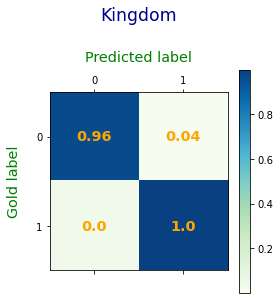

In [14]:
# 6.2.4 Visualise the results
cm_k = confusion_matrix(gold_labs_k, pred_labs_k, normalize = 'pred')

plt.figure()
plt.matshow(cm_k, cmap = plt.cm.GnBu)
plt.colorbar()

for i in range(cm_k.shape[0]):
    for j in range(cm_k.shape[1]):
        plt.text(i,j,str(round(cm_k[i][j],2)),color='orange',fontsize='x-large',ha='center',va='center',weight='semibold')

plt.xlabel('Predicted label',labelpad=-220, fontsize='x-large',color= 'green')
plt.ylabel('Gold label',labelpad=15, fontsize='x-large',color= 'green')
plt.title('Kingdom', fontsize='xx-large',pad=30,color= 'darkblue')
plt.show()

In [15]:
# 6.2.2 Make predictions for kingdom
trained_model_lstm_k = joblib.load('stl_kingdom_n1_la7_b64_lr0_op.model')

gold_labs_k, pred_labs_k = predict_nn(trained_model_lstm_k, test_loader_k) # Predict the results of test data 

# 6.2.3 Evaluate the kingdom
acc_k = accuracy_score(gold_labs_k, pred_labs_k)
print(f'Accuracy = {acc_k}')

f1_k = f1_score(gold_labs_k, pred_labs_k, average='macro')
print(f'F1 score (macro average) = {f1_k}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(gold_labs_k, pred_labs_k))

prec_k = precision_score(gold_labs_k, pred_labs_k, average='macro')
print(f'Precision (macro average) = {prec_k}')

rec_k = recall_score(gold_labs_k, pred_labs_k, average='macro')
print(f'Recall (macro average) = {rec_k}')

Accuracy = 0.9982272995863699
F1 score (macro average) = 0.9821707074865236
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       132
           1       1.00      1.00      1.00      4945

    accuracy                           1.00      5077
   macro avg       0.99      0.97      0.98      5077
weighted avg       1.00      1.00      1.00      5077

Precision (macro average) = 0.9914189135448979
Recall (macro average) = 0.9732826240156878


<Figure size 432x288 with 0 Axes>

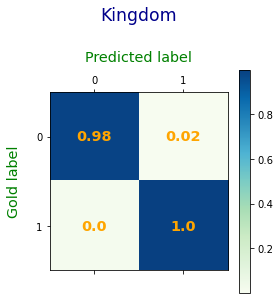

In [17]:
# 6.2.4 Visualise the results
cm_k = confusion_matrix(gold_labs_k, pred_labs_k, normalize = 'pred')

plt.figure()
plt.matshow(cm_k, cmap = plt.cm.GnBu)
plt.colorbar()

for i in range(cm_k.shape[0]):
    for j in range(cm_k.shape[1]):
        plt.text(i,j,str(round(cm_k[i][j],2)),color='orange',fontsize='x-large',ha='center',va='center',weight='semibold')

plt.xlabel('Predicted label',labelpad=-220, fontsize='x-large',color= 'green')
plt.ylabel('Gold label',labelpad=15, fontsize='x-large',color= 'green')
plt.title('Kingdom', fontsize='xx-large',pad=30,color= 'darkblue')
plt.show()

**$\cdot$Phylum**

In [22]:
# 6.3 Phylum
# 6.3.1 Construct and train a LSTM model for phylum
model_lstm_p= DNAClassifierWithLSTM(vocab_size, embedding_size, hidden_size, hidden_size_p, num_layers, num_classes_p) # Creat a LSTM
trained_model_lstm_p = train_nn(num_epochs, learning_rate, model_lstm_p, train_loader_p, dev_loader_p) # Train model

Epoch: 1/10 Training Loss: 2.3980 Training Accuracy: 38.1641%
Epoch: 1/10 Validation Loss: 1.6373 Validation Accuracy: 55.1588%
Epoch: 2/10 Training Loss: 1.4173 Training Accuracy: 63.5597%
Epoch: 2/10 Validation Loss: 0.9726 Validation Accuracy: 74.3905%
Epoch: 3/10 Training Loss: 0.9353 Training Accuracy: 76.0266%
Epoch: 3/10 Validation Loss: 0.6862 Validation Accuracy: 82.5659%
Epoch: 4/10 Training Loss: 0.6754 Training Accuracy: 83.0758%
Epoch: 4/10 Validation Loss: 0.5095 Validation Accuracy: 86.6535%
Epoch: 5/10 Training Loss: 0.5255 Training Accuracy: 86.8805%
Epoch: 5/10 Validation Loss: 0.3825 Validation Accuracy: 89.5100%
Epoch: 6/10 Training Loss: 0.4233 Training Accuracy: 89.1646%
Epoch: 6/10 Validation Loss: 0.3064 Validation Accuracy: 91.9232%
Epoch: 7/10 Training Loss: 0.3410 Training Accuracy: 91.1962%
Epoch: 7/10 Validation Loss: 0.2567 Validation Accuracy: 93.0559%
Epoch: 8/10 Training Loss: 0.2867 Training Accuracy: 92.5383%
Epoch: 8/10 Validation Loss: 0.2044 Valida

In [23]:
joblib.dump(trained_model_lstm_p, 'stl_phylum_n1_la7_b64_lr0.model')

['stl_phylum_n1_la7_b64_lr0.model']

Prediction

In [18]:
# 6.3.2 Make predictions for phylum
trained_model_lstm_p = joblib.load('stl_phylum_n1_la7_b64_lr0.model')

gold_labs_p, pred_labs_p = predict_nn(trained_model_lstm_p, test_loader_p) # Predict the results of test data 

# 6.3.3 Evaluate the phylum
acc_p = accuracy_score(gold_labs_p, pred_labs_p)
print(f'Accuracy = {acc_p}')

prec_p = precision_score(gold_labs_p, pred_labs_p, average='macro')
print(f'Precision (macro average) = {prec_p}')

rec_p = recall_score(gold_labs_p, pred_labs_p, average='macro')
print(f'Recall (macro average) = {rec_p}')

f1_p = f1_score(gold_labs_p, pred_labs_p, average='macro')
print(f'F1 score (macro average) = {f1_p}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(gold_labs_p, pred_labs_p))

Accuracy = 0.9306677171558007
Precision (macro average) = 0.6607995938105096
Recall (macro average) = 0.6280461823647484
F1 score (macro average) = 0.6183628711799318
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      0.90      0.93       316
           2       0.95      0.95      0.95       350
           3       0.56      0.43      0.49        21
           4       0.00      0.00      0.00         2
           5       0.99      0.98      0.99       651
           6       0.00      0.00      0.00         3
           7       0.90      0.93      0.91        28
           8       0.46      0.88      0.61        26
           9       0.80      0.88      0.84       195
          10       0.89      0.81      0.85        21
          11       0.95      0.93      0.94       169
          12       0.80      0.61      0.69        33
          13       0.78      0.78      0.78        18
          14       1.0

C:\Users\Angela.Chen\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Angela.Chen\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Angela.Chen\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Angela.Chen\miniconda3\lib\site-packag

<Figure size 432x288 with 0 Axes>

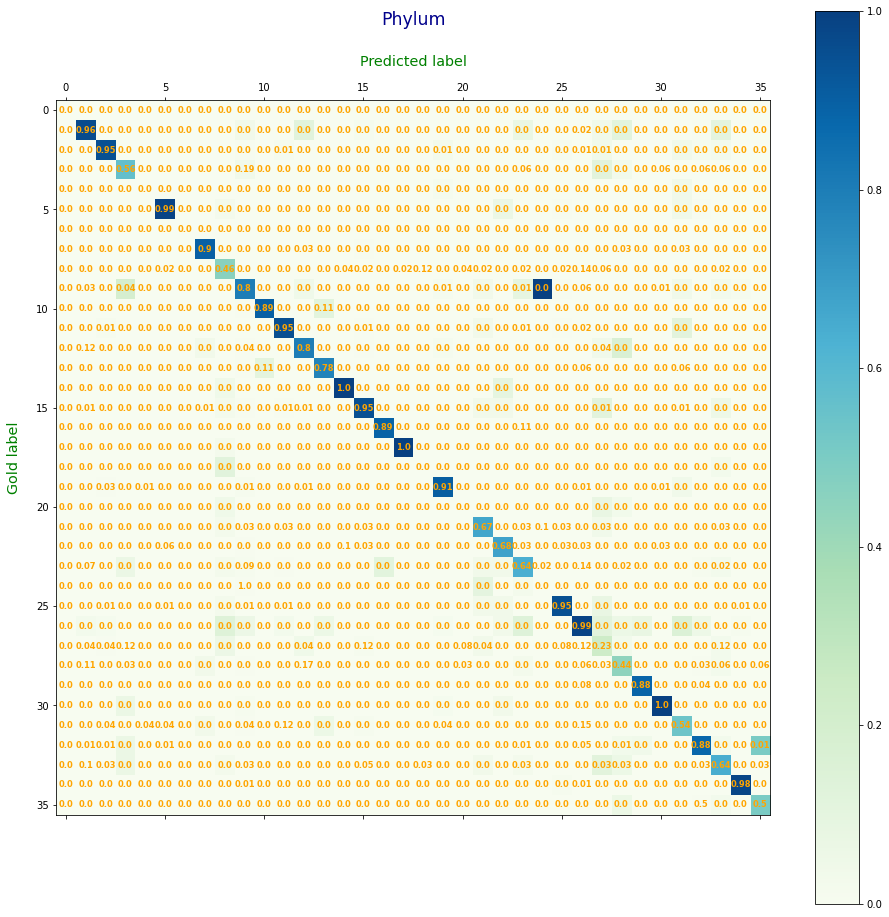

In [19]:
# 6.3.4 Visualise the results
cm_p = confusion_matrix(gold_labs_p, pred_labs_p, normalize = 'pred')

plt.figure()
plt.rcParams["figure.figsize"] = [100.00, 50.00]
plt.matshow(cm_p, cmap = plt.cm.GnBu)
plt.colorbar()

for i in range(cm_p.shape[0]):
    for j in range(cm_p.shape[1]):
        plt.text(i,j,str(round(cm_p[i][j],2)),color='orange',fontsize='small',ha='center',va='center',weight='semibold')

plt.xlabel('Predicted label',labelpad=-760, fontsize='x-large',color= 'green')
plt.ylabel('Gold label',labelpad=15, fontsize='x-large',color= 'green')
plt.title('Phylum', fontsize='xx-large',pad=30,color= 'darkblue')
plt.show()

**$\cdot$Class**

In [ ]:
# 6.4 Class
# 6.4.1 Construct and train a LSTM model for phylum
model_lstm = DNAClassifierWithLSTM(vocab_size, embedding_size, hidden_size, hidden_size_c, num_layers, num_classes_c) # Creat a LSTM
trained_model_lstm_c = train_nn(num_epochs, learning_rate, model_lstm, train_loader_c,dev_loader_c) # Train model

Epoch: 1/10 Training Loss: 3.3745 Training Accuracy: 23.3578%
Epoch: 1/10 Validation Loss: 2.3052 Validation Accuracy: 44.2502%
Epoch: 2/10 Training Loss: 1.9380 Training Accuracy: 54.3742%
Epoch: 2/10 Validation Loss: 1.4035 Validation Accuracy: 66.9293%
Epoch: 3/10 Training Loss: 1.3157 Training Accuracy: 68.9035%
Epoch: 3/10 Validation Loss: 0.9443 Validation Accuracy: 77.0992%
Epoch: 4/10 Training Loss: 0.9804 Training Accuracy: 76.2913%
Epoch: 4/10 Validation Loss: 0.6936 Validation Accuracy: 82.7875%
Epoch: 5/10 Training Loss: 0.7579 Training Accuracy: 81.7768%
Epoch: 5/10 Validation Loss: 0.5331 Validation Accuracy: 86.3580%
Epoch: 6/10 Training Loss: 0.6013 Training Accuracy: 85.4276%
Epoch: 6/10 Validation Loss: 0.4128 Validation Accuracy: 89.5592%
Epoch: 7/10 Training Loss: 0.4979 Training Accuracy: 87.4654%
Epoch: 7/10 Validation Loss: 0.3297 Validation Accuracy: 91.7262%
Epoch: 8/10 Training Loss: 0.4166 Training Accuracy: 89.7494%
Epoch: 8/10 Validation Loss: 0.2799 Valida

In [ ]:
joblib.dump(trained_model_lstm_c, 'stl_class_n1_la7_b64_lr0.model')

['stl_class_n1_la7_b64_lr0.model']

Prediction

In [21]:
# 6.4.2 Make predictions for class
trained_model_lstm_c = joblib.load('stl_class_n1_la7_b64_lr0.model')

gold_labs_c, pred_labs_c = predict_nn(trained_model_lstm_c, test_loader_c) # Predict the results of test data 

# 6.4.3 Evaluate the class
acc_c = accuracy_score(gold_labs_c, pred_labs_c)
print(f'Accuracy = {acc_c}')

prec_c = precision_score(gold_labs_c, pred_labs_c, average='macro')
print(f'Precision (macro average) = {prec_c}')

rec_c = recall_score(gold_labs_c, pred_labs_c, average='macro')
print(f'Recall (macro average) = {rec_c}')

f1_c = f1_score(gold_labs_c, pred_labs_c, average='macro')
print(f'F1 score (macro average) = {f1_c}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(gold_labs_c, pred_labs_c))

Accuracy = 0.9158952137088832
Precision (macro average) = 0.7445528601760486
Recall (macro average) = 0.6990395367023364
F1 score (macro average) = 0.696314537977747
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.69      0.56      0.62        16
           2       0.53      0.56      0.54        18
           3       0.00      0.00      0.00         1
           4       1.00      0.33      0.50         3
           5       0.94      0.92      0.93        71
           6       0.83      0.83      0.83        12
           7       0.99      0.91      0.94        74
           8       1.00      0.94      0.97        34
           9       0.98      0.98      0.98       172
          10       0.95      0.97      0.96       647
          11       0.85      0.87      0.86        90
          12       0.00      0.00      0.00         2
          13       1.00      0.75      0.86         4
          14       0.67

C:\Users\Angela.Chen\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Angela.Chen\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Angela.Chen\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Angela.Chen\miniconda3\lib\site-packages\sklearn\metrics\_c

<Figure size 7200x3600 with 0 Axes>

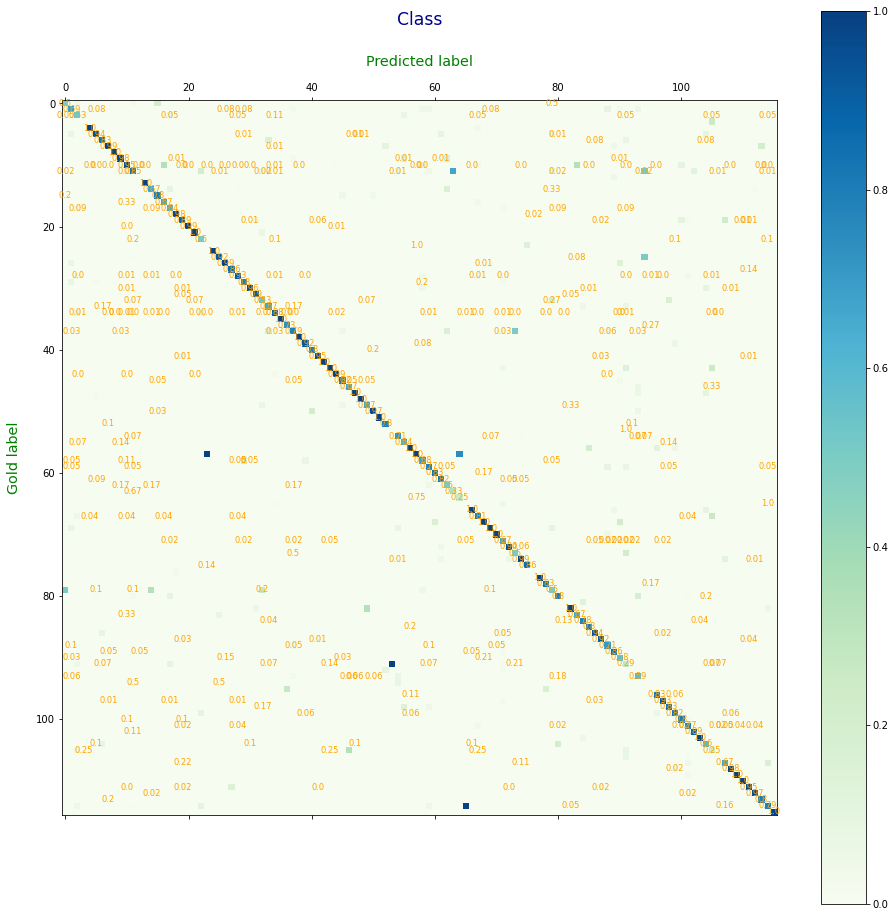

In [22]:
# 6.4.4 Visualise the results
cm_c = confusion_matrix(gold_labs_c, pred_labs_c, normalize = 'pred')

plt.figure()
plt.rcParams["figure.figsize"] = [100.00, 50.00]
plt.matshow(cm_c, cmap = plt.cm.GnBu)
plt.colorbar()

for i in range(cm_c.shape[0]):
    for j in range(cm_c.shape[1]):
        if cm_c[i][j] !=0:
            plt.text(i,j,str(round(cm_c[i][j],2)),color='orange',fontsize='small',ha='center',va='center',weight='normal')

plt.xlabel('Predicted label',labelpad=-760, fontsize='x-large',color= 'green')
plt.ylabel('Gold label',labelpad=15, fontsize='x-large',color= 'green')
plt.title('Class', fontsize='xx-large',pad=30,color= 'darkblue')
plt.show()